In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

EJERCICIO 1

In [2]:
#Constantes de la ecuacion
EI=1.8e7
w_o=15e3
L=5

#Grilla y condicion inicial
cond_inicial=[0,0]
a,b= 0, L
h=0.01
n=int((b-a)/h)-1
grid=np.arange(a+h,b,h,dtype='float64')

In [3]:
#Funcion F=(F1, ..., Fn-1)
def F(y):
    x=grid
    h2=h**2

    res=np.zeros(n,dtype='float64')
    res[0]=(EI/h2)*(y[1]-2*y[0])
    res[0]+=(w_o/2)*(x[0]**2 - (L*x[0]))*((1 + ((y[1]/(2*h))**2))**(3/2))
    res[-1]=(EI/h2)*(y[-2]-2*y[-1])
    res[-1]+=(w_o/2)*(x[-1]**2 - (L*x[-1]))*((1 + ((y[-2]/(2*h))**2))**(3/2))
    for i in range(1, n-1):
        res[i]=(EI/h2)*(y[i+1]-(2*y[i])+y[i-1])
        res[i]+=(w_o/2)*(x[i]**2 - (L*x[i]))*((1 + ((y[i+1]-y[i-1])/(2*h))**2)**(3/2))
    return res

In [4]:
#Derivada de F
def Fprime(y):
    x=grid
    A=np.zeros((n,n))
    h2=h**2
    for i in range(n):
        A[i,i] = -2*EI/(h2)
    
    for i in range(1,n-1):
        A[i,i+1]=EI/h2
        A[i,i+1]+=(3/2)*((4*h2)**(2/3))*(x[i]**2 - (L*x[i]))*(y[i+1]-y[i-1])*(((4*h2)+((y[i+1]-y[i-1])**2))**0.5)
        A[i,i-1]=A[i,i+1]
    return A

In [5]:
#Metodo de newton que resuelve F=0
def Newton(y, Prime, F, it, tol):
    sol=np.ones(n)    
    k=0
    while np.linalg.norm(sol) > tol and k < it:
        sol= np.linalg.solve(Prime(y), -F(y))
        y = y + sol
        k += 1
    return y

In [6]:
sol1=Newton(y=np.ones(n), Prime=Fprime,F=F, it=100, tol=1e-8)
#sol1=Newton(y=np.zeros(n), Prime=Fprime,F=F, it=100, tol=1e-8)

In [7]:
#Agrego las condiciones iniciales a las soluciones
sol, steps=np.ones(n+2), np.ones(n+2)
sol[0], sol[-1]= cond_inicial
sol[1:-1]=sol1
steps[0], steps[-1]=a, b
steps[1:-1]=grid

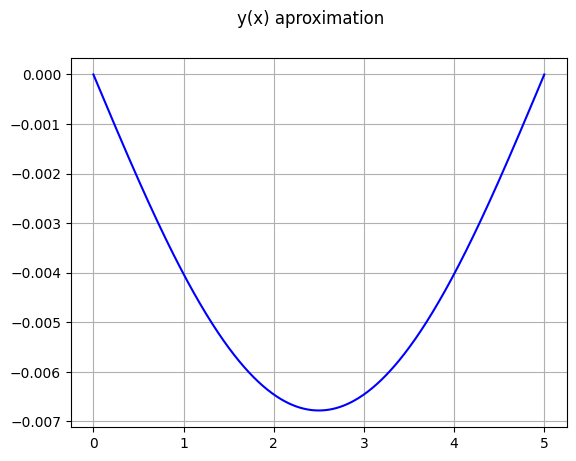

In [8]:
fig, ax=plt.subplots()
ax.plot(steps,sol, color="blue")
plt.suptitle("y(x) aproximation")
plt.grid(True)
plt.show()

EJERCICIO 2

In [9]:
#Uso a=0, b=1, g1=0, g2=0
def u0(x):
    return np.sin(np.pi*x)

def f(t,x):
    return np.zeros(x.shape)
    
def g1(t):
    return 0

def g2(t):
    return 0

In [10]:
#Runge-Kutta 4th order
def RK4(fun,t0,T,x_0,h):
    def F1(t, x, h):
        return h*fun(t, x) 
    def F2(t, x, h):
        return h*fun(t + (h/2), x + F1(t, x, h)/2)
    def F3(t, x, h):
        return h*fun(t + (h/2), x + F2(t, x, h)/2)
    def F4(t, x, h):
        return h*fun(t + h, x + F3(t, x, h))
    
    sol=[x_0]
    steps=np.arange(t0,T,h,dtype=float) 
    #steps=np.append(steps, T)
    for t in steps[1:]:
        x_0= x_0 + (1/6)*(F1(t, x_0, h) + 2*F2(t, x_0, h) + 2*F3(t, x_0, h) + F4(t, x_0, h))
        sol.append(x_0)
    sol=np.array(sol, dtype=float)
    return sol, steps

In [11]:
#Crank-Nicolson scheme for 1D PDE
#interval [a,b], final time T, u0,g1,g2 initial condition, f non homogeneous term
def Cranck_Nicolson(a,b,T,hx,ht,f,u0, g1, g2):
    m=int(T/ht)
    n=int((b-a)/hx)
    A=np.eye(n)*(2)
    A+=np.diag(-np.ones(n-1),1)
    A+=np.diag(-np.ones(n-1),-1)
    A*=ht/(2*(hx**2)) #*beta but beta=1
    
    spacial_steps=np.arange(a,b,hx)
    temp_steps=np.arange(0,T,ht)
    initial_cond=np.array([u0(i) for i in spacial_steps], dtype=float)   
    
    def g(t):
        gg=np.zeros(n)
        gg[0], gg[-1]=g1(t)+g1(t+ht), g2(t)+g2(t+ht)
        return gg/(2*(hx**2))

    def F(t,X):
        return ht*0.5*(f(t,X)+f(t+ht,X)) + g(t)
    
    A1=np.eye(n)+A
    A2=np.eye(n)-A
    sol=np.zeros((m+1,n))
    sol[0,:]=initial_cond
    for i in range(1,m):
        sol[i,:]=np.linalg.solve(A1, A2 @ sol[i-1, :] + F(ht*i,spacial_steps))
    return sol, spacial_steps, temp_steps

In [12]:
def grafico1():
    sol, spacial_steps, temp_steps=Cranck_Nicolson(a=0,b=1,T=1,hx=0.1,ht=0.00512,f=f,u0=u0, g1=g1, g2=g2)
    t,x=np.meshgrid(temp_steps, spacial_steps)
    t,x=t.T,x.T

    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    surf=ax.plot_surface(x,t, sol, rstride=1, cstride=1,cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5, label="Aprox Solution")
    plt.suptitle("Δx=0.1    Δt=0.005125   M=200")
    ax.set_xlabel('[x]')
    ax.set_ylabel('[t]')
    ax.set_zlabel('µ')
    plt.show()

In [13]:
def grafico2():
    sol, spacial_steps, temp_steps=Cranck_Nicolson(a=0,b=1,T=1,hx=0.1,ht=0.006,f=f,u0=u0, g1=g1, g2=g2)
    t,x=np.meshgrid(temp_steps, spacial_steps)
    t,x=t.T,x.T

    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    surf=ax.plot_surface(x,t, sol, rstride=1, cstride=1,cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5, label="Aprox Solution")
    plt.suptitle("Δx=0.1   Δt=0.006   M=171")
    ax.set_xlabel('[x]')
    ax.set_ylabel('[t]')
    ax.set_zlabel('µ')
    plt.show()

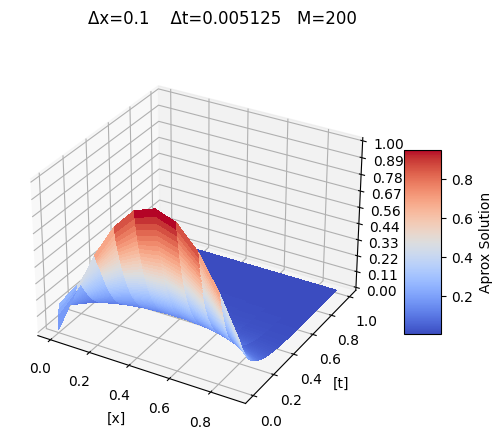

In [14]:
grafico1()

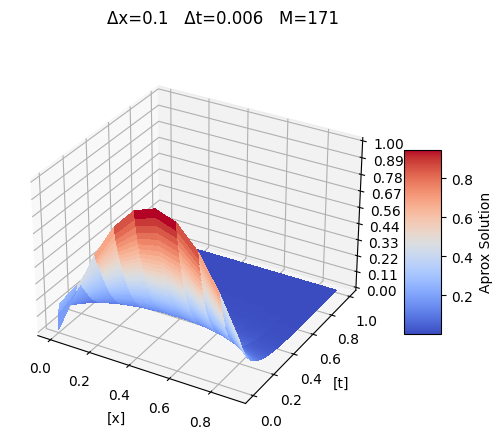

In [15]:
grafico2()